In [ ]:
#import libraries
import pandas as pd
import numpy as np
import torch
import helpers
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from pyro.optim import ClippedAdam, Adam
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import time

# fix random generator seed (for reproducibility of results)
seed=666
pyro.set_rng_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# set matplotlib style options
plt.style.use('seaborn')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# **Data preprocessing**

if you already have the .pkl file you can scroll below to section 'BNN model - Predicting Demand'

In [37]:
#-----______-----______-----______-----______-----
# Initialize by gathering and grouping produciton data
#-----______-----______-----______-----______-----

df = pd.read_csv("ProductionConsumptionSettlement.csv", delimiter=";")

# Convert columns to appropriate data types
df['HourUTC'] = pd.to_datetime(df['HourUTC'])
df['HourDK'] = pd.to_datetime(df['HourDK'])
# Convert columns to numeric format (replacing commas with dots)
columns_to_convert = ['CentralPowerMWh', 'LocalPowerMWh',
                      'CommercialPowerMWh', 'LocalPowerSelfConMWh', 'OffshoreWindLt100MW_MWh',
                      'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh',
                      'OnshoreWindGe50kW_MWh', 'HydroPowerMWh', 'SolarPowerLt10kW_MWh',
                      'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh',
                      'SolarPowerSelfConMWh', 'UnknownProdMWh', 'ExchangeNO_MWh',
                      'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh',
                      'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh',
                      'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
                      'GridLossDistributionMWh', 'PowerToHeatMWh']

df[columns_to_convert] = df[columns_to_convert].apply(lambda x: x.str.replace(',', '.')).astype(float)

df['Wind'] = df[['OffshoreWindLt100MW_MWh', 'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh', 'OnshoreWindGe50kW_MWh']].sum(axis=1)
df['Hydro'] = df['HydroPowerMWh']
df['Solar'] = df[['SolarPowerLt10kW_MWh', 'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh', 'SolarPowerSelfConMWh']].sum(axis=1)
df['Power'] = df[['CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh']].sum(axis=1)
df['Exchange'] = df[['CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh']].sum(axis=1)


# Rename and drops
df.rename(columns={'UnknownProdMWh': 'Unknown_Production'}, inplace=True)

df.drop(['OffshoreWindLt100MW_MWh', 'OffshoreWindGe100MW_MWh', 'OnshoreWindLt50kW_MWh', 'OnshoreWindGe50kW_MWh',
         'HydroPowerMWh', 'SolarPowerLt10kW_MWh', 'SolarPowerGe10Lt40kW_MWh', 'SolarPowerGe40kW_MWh', 'SolarPowerSelfConMWh',
         'CentralPowerMWh', 'LocalPowerMWh', 'CommercialPowerMWh', 'LocalPowerSelfConMWh'], axis=1, inplace=True)

df = df[['HourUTC', 'HourDK', 'PriceArea', 'Wind', 'Hydro', 'Solar', 'Power', 'Unknown_Production',
         'ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh',
         'ExchangeGreatBelt_MWh', 'GrossConsumptionMWh', 'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
         'GridLossDistributionMWh', 'PowerToHeatMWh']]

## fill Exhcnage NAn with 0
df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'ExchangeGreatBelt_MWh']] = df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'ExchangeGreatBelt_MWh']].fillna(0)

# Merge the exchanges
df['Exchange'] = df[['ExchangeNO_MWh','ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh']].sum(axis=1)
exchange_columns = ['ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh']
df[exchange_columns] = df[exchange_columns].fillna(0)

df['GridLoss'] = df[['GridLossTransmissionMWh', 'GridLossInterconnectorsMWh', 'GridLossDistributionMWh','PowerToHeatMWh']].sum(axis=1)
grid_loss_columns = ['GridLossTransmissionMWh', 'GridLossInterconnectorsMWh', 'GridLossDistributionMWh', 'PowerToHeatMWh']
df['GridLoss'] = df[grid_loss_columns].sum(axis=1)

## finally drop the columns:
df.drop(['ExchangeNO_MWh', 'ExchangeSE_MWh', 'ExchangeGE_MWh', 'ExchangeNL_MWh', 'ExchangeGB_MWh', 'GridLossTransmissionMWh', 'GridLossInterconnectorsMWh',
         'GridLossDistributionMWh', 'PowerToHeatMWh'], axis=1, inplace=True)

#-----______-----______-----______-----______-----
# Gather Weather data
#-----______-----______-----______-----______-----
import requests
#data collected from https://open-meteo.com/ --- code is inspired from documentation

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": 56.2639,  # Latitude of Denmark
    "longitude": 9.5018,  # Longitude of Denmark
    "start_date": "2022-01-01",
    "end_date": "2024-03-01",
	"hourly": ["temperature_2m", "precipitation", "cloud_cover", "wind_speed_10m"],
	"wind_speed_unit": "ms",
	"timezone": "Europe/Berlin"
}

# Make the HTTP request
response = requests.get(url, params=params)
data = response.json()

# Process hourly data. The order of variables needs to be the same as requested.
hourly = data['hourly']
hourly_temperature_2m = hourly['temperature_2m']
hourly_precipitation = hourly['precipitation']
hourly_cloud_cover = hourly['cloud_cover']
hourly_wind_speed_10m = hourly['wind_speed_10m']

df_weather = pd.DataFrame()
df_weather['Datetime'] = pd.to_datetime(hourly['time'])
df_weather['hourly_temperature_2m'] = hourly_temperature_2m #°C
df_weather['precipitation'] = hourly_precipitation #mm
df_weather['cloud_cover'] = hourly_cloud_cover #% of sky
df_weather['hourly_wind_speed_10m'] = hourly_wind_speed_10m #already in m/s      #[speed/3.6 for speed in hourly_wind_speed_10m] #km/h to m/s

#-----______-----______-----______-----______-----
# Initialize Spot price Data
#-----______-----______-----______-----______-----
## data collected from https://www.energidataservice.dk/tso-electricity/Elspotprices

price_df = pd.read_csv('Elspotprices.csv', sep=';')

price_df['HourUTC'] = pd.to_datetime(price_df['HourUTC'])
price_df['HourDK'] = pd.to_datetime(price_df['HourDK'])

price_df['SpotPriceDKK'] = price_df['SpotPriceDKK'].str.replace(',', '.').astype(float)
price_df['SpotPriceEUR'] = price_df['SpotPriceEUR'].str.replace(',', '.').astype(float)

# Display the first few rows of the DataFrame
price_df.head(2)

,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2024-03-31 21:00:00,2024-03-31 23:00:00,DK1,409.480011,54.900002
1,2024-03-31 21:00:00,2024-03-31 23:00:00,DK2,409.480011,54.900002


In [38]:
#-----______-----______-----______-----______-----
# Merge DataFrames defined above
#-----______-----______-----______-----______-----
mini_merged_df = pd.merge(df, price_df, on=['HourUTC', 'HourDK', 'PriceArea'], how='left')

# Merge the DataFrames on 'HourDK' and 'Datetime'
merged_df = pd.merge(mini_merged_df, df_weather, left_on='HourDK', right_on='Datetime', how='left')
merged_df.drop('Datetime', axis=1, inplace=True)

missing_values_exist = False

for column in merged_df.columns:
    num_missing = merged_df[column].isna().sum()
    if num_missing > 0:
        missing_values_exist = True
        print(f"Column '{column}' has {num_missing} missing values.")
if not missing_values_exist:
    print("No missing vlaues found.")

#Remove rows where PriceArea == 'DK1'
merged_df_DK1 = merged_df[merged_df['PriceArea'] != 'DK2']
merged_df_DK2 = merged_df[merged_df['PriceArea'] != 'DK1']

No missing vlaues found.


When modelling Denmark we have two areas, DK1 and DK2. DK1 being west Denmark.

It gets complex to model the interactions between these two areas as 'one' system due to their energy exchange, as such we only model one of the DK areas.

In [39]:
print("Descriptive statistics for DK2 DATA")
merged_df_DK2.describe() 

Descriptive statistics for DK2 DATA


,HourUTC,HourDK,Wind,Hydro,Solar,Power,Unknown_Production,ExchangeGreatBelt_MWh,GrossConsumptionMWh,Exchange,GridLoss,SpotPriceDKK,SpotPriceEUR,hourly_temperature_2m,precipitation,cloud_cover,hourly_wind_speed_10m
count,18960,18960,18960.000000,1.896000e+04,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000,18960.000000
mean,2023-01-30 22:30:00,2023-01-31 00:02:57.721518848,620.992705,1.424051e-09,81.208136,513.002146,5.646906,-4.337110,1555.584361,339.071578,131.868586,1039.858023,139.715917,8.657078,0.108486,59.599736,4.320082
min,2021-12-31 23:00:00,2022-01-01 00:00:00,0.020450,0.000000e+00,0.016974,36.676712,0.000000,-600.500000,920.682494,-1238.010000,61.358626,-447.250000,-60.040001,-13.000000,0.000000,0.000000,0.000000
25%,2022-07-17 10:45:00,2022-07-17 12:45:00,162.259335,0.000000e+00,0.128680,300.471887,1.656310,-307.725000,1345.734113,98.396889,94.515112,426.039993,57.215001,3.800000,0.000000,23.000000,2.750000
50%,2023-01-30 22:30:00,2023-01-30 23:30:00,529.051518,0.000000e+00,2.040500,474.752141,3.660379,0.000000,1550.158537,392.776375,117.240475,768.349976,103.110000,8.200000,0.000000,68.000000,4.050000
75%,2023-08-16 10:15:00,2023-08-16 12:15:00,1057.701587,0.000000e+00,104.467753,722.797884,7.590354,294.900000,1755.296648,648.095562,156.894951,1361.157501,183.000000,13.800000,0.000000,100.000000,5.590000
max,2024-02-29 22:00:00,2024-02-29 23:00:00,1616.020234,3.000000e-06,666.012696,1326.089467,260.130291,594.900000,2568.070218,2051.025750,951.061298,6478.240234,871.000000,32.200000,8.300000,100.000000,13.970000
std,NaN,NaN,487.043285,4.760277e-08,138.080678,263.039449,11.797776,364.366647,304.925768,460.284479,49.079017,939.927816,126.377246,6.639388,0.382470,38.508783,2.057996


In [40]:
merged_df_DK1.head(2)

,HourUTC,HourDK,PriceArea,Wind,Hydro,Solar,Power,Unknown_Production,ExchangeGreatBelt_MWh,GrossConsumptionMWh,Exchange,GridLoss,SpotPriceDKK,SpotPriceEUR,hourly_temperature_2m,precipitation,cloud_cover,hourly_wind_speed_10m
0,2021-12-31 23:00:00,2022-01-01 00:00:00,DK1,2055.764409,1.637731,0.074532,609.812186,0.0,385.2,2196.288858,-856.20,360.817724,372.200012,50.049999,7.0,0.0,100,4.14
2,2022-01-01 00:00:00,2022-01-01 01:00:00,DK1,2039.635142,1.641966,0.068892,550.685591,0.0,356.5,2206.261591,-742.27,417.870739,307.350006,41.330002,7.4,0.0,100,4.10


### Descriptive stats

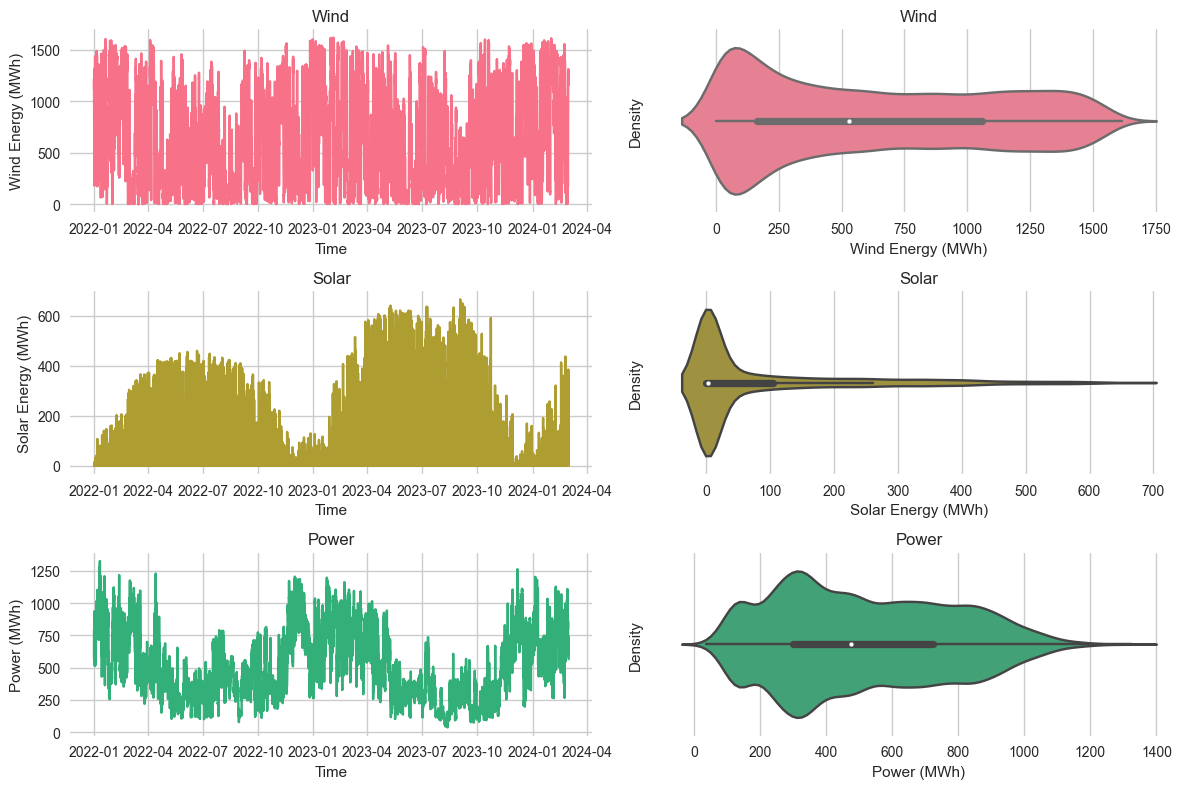

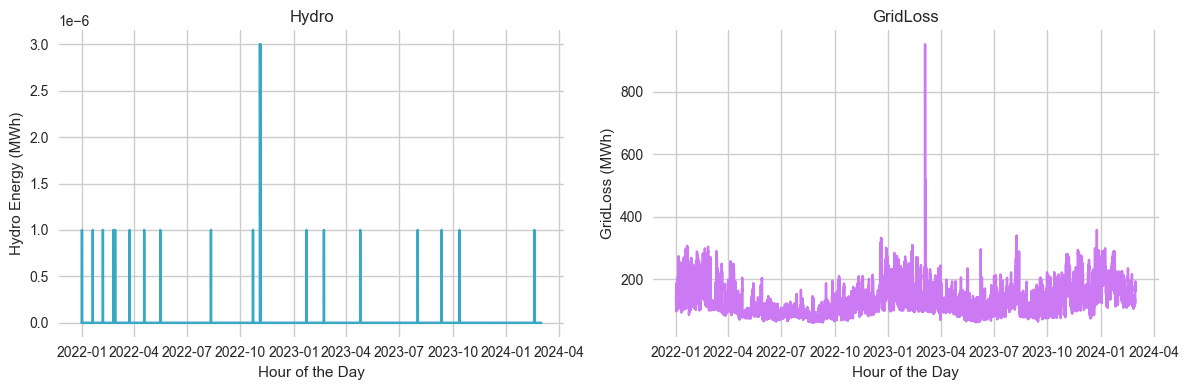

In [41]:
helpers.plot1(merged_df_DK2) #The following commands for visualization are defined in helpers.py

From this we can get an initial overview of the distributions of the energy. Especially that wind greatly fluctuates, but produces quite a large amount of power.

Solar power is cyclical especially during the 'summer' periods, but also has a large amount of down-time (we can also see this in the next plots)

Additionally, power is a pretty stable power production and never reaches 0

Lastly Hydro is sparcely used, and barely produces anything, thus we may need to consider removing it. Additionally, grid loss amounts for a non-negligible power 'user'. To simplify the model, the gridloss will be combined with power, and will not be considered in this analysis.

Next we can plot the hourly development, also including the weather data:

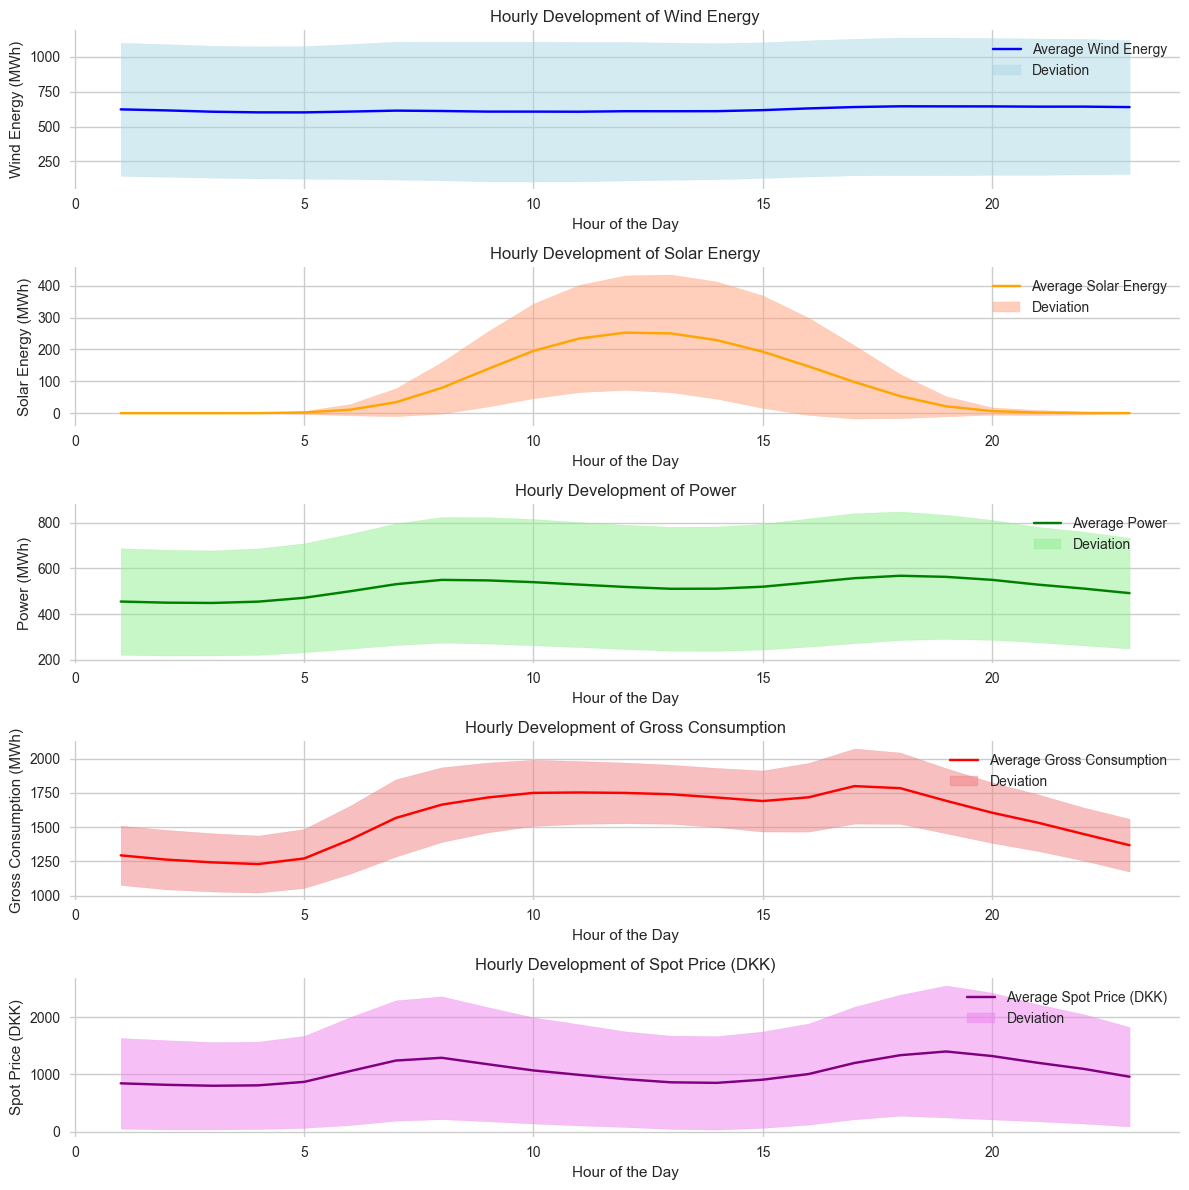

In [42]:
helpers.plot2(merged_df_DK2)

From the above plots, we can especially see the time dependence of solar energy. Additionally, the general power plants don't largely vary, but their average does seem to be multimodal around peak times. Possibly to anticipate peak demand around those times.

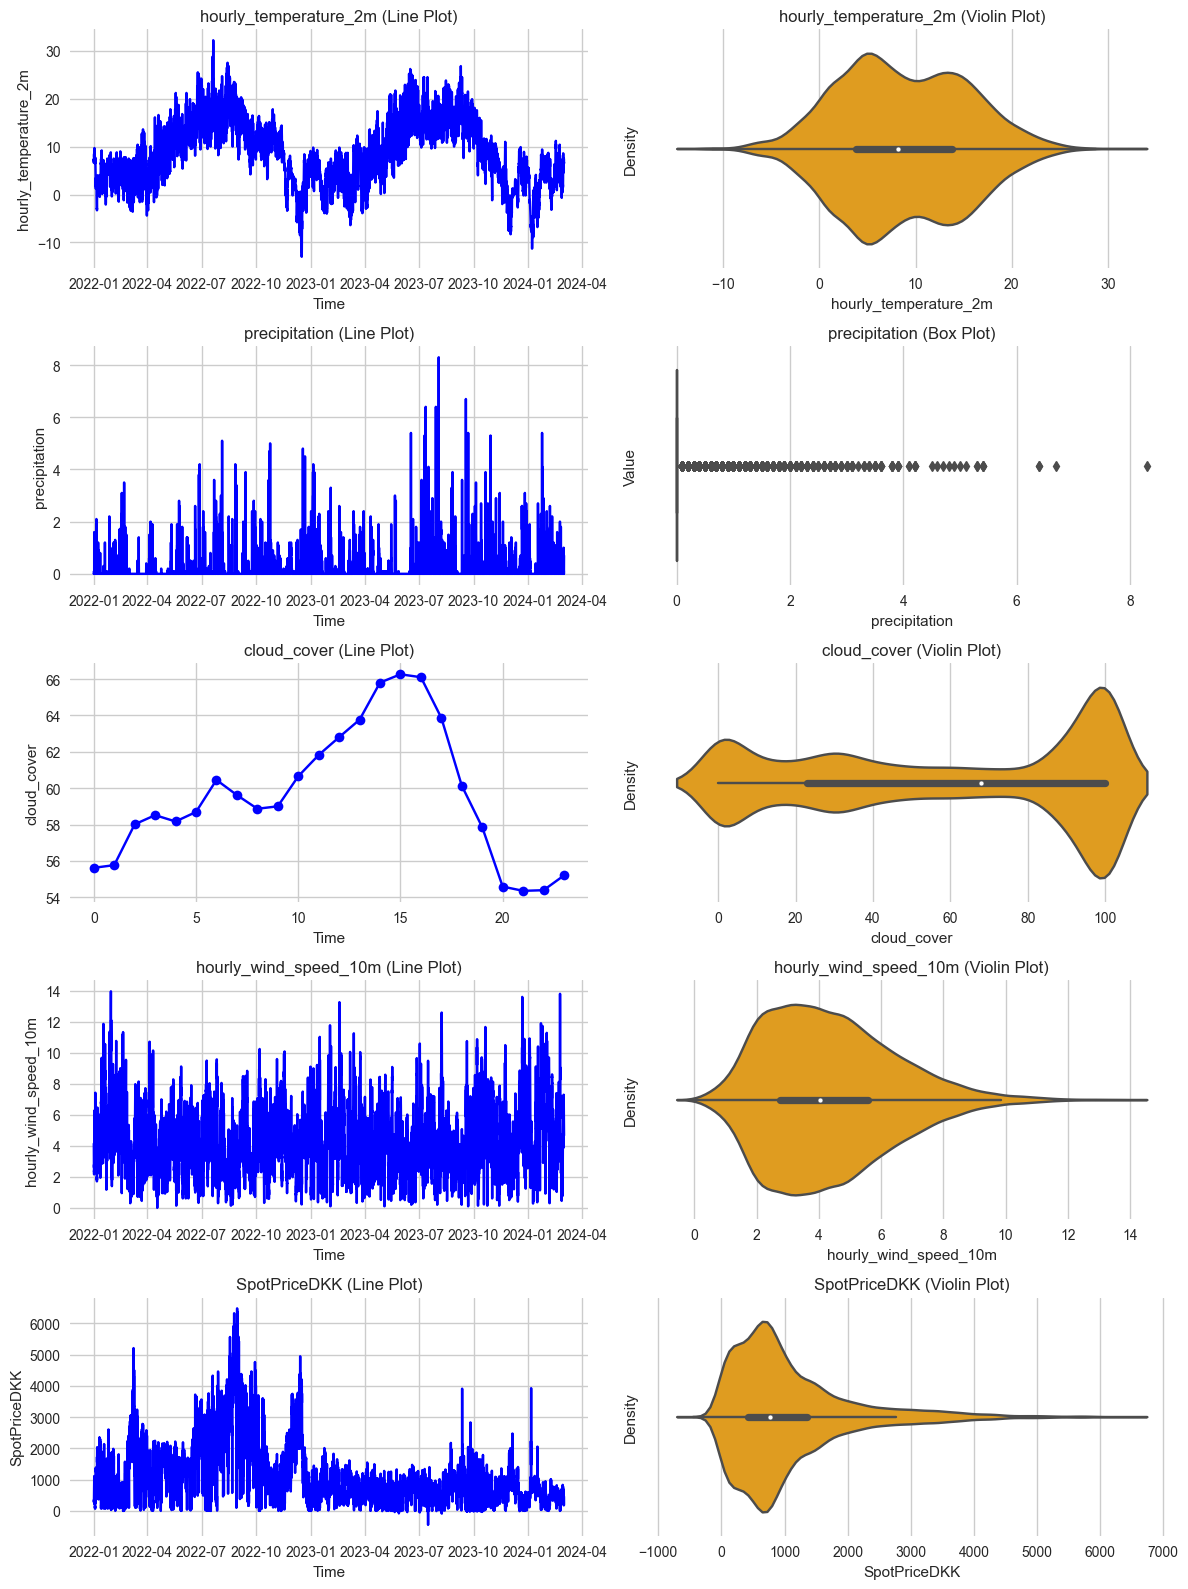

In [43]:
helpers.plot3(merged_df_DK2)

With regards to the weather data shown above, we can see that they are both dependent on the time of day and season, but also exhibit some degree of randomness such as with or precipitation. Additionally, the spot prices vary significantly, some even becoming negative.

Next we can use a correlation plot to highlight the assumption of the weather having an, as well as on the consumption.

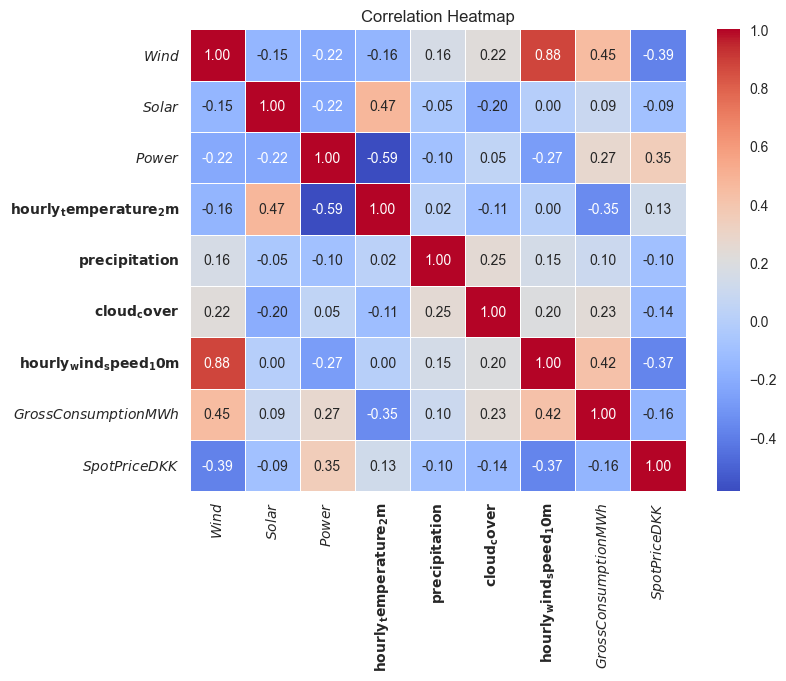

In [44]:
correlation_matrix = merged_df_DK1[['Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'precipitation', 'cloud_cover', 'hourly_wind_speed_10m','GrossConsumptionMWh','SpotPriceDKK']].corr()
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
weather_features = ['hourly_temperature_2m', 'precipitation', 'cloud_cover', 'hourly_wind_speed_10m']
ax = plt.gca()
ax.set_xticklabels([f'$\mathbf{{{label}}}$' if label in weather_features else f'${label}$' for label in correlation_matrix.columns])
ax.set_yticklabels([f'$\mathbf{{{label}}}$' if label in weather_features else f'${label}$' for label in correlation_matrix.index])
plt.title('Correlation Heatmap')
plt.show()


From the above correlation plot we can see that the features that are most correlated are the Wind (generation) and the wind speed. This is to be expected as there needs to be 'wind' for wind-turbines to generate electricity. We can also see that they both have simmilar correlations to the GrossConsumption, are 0.45 and 0.42 for wind generation and speed respectively.

Therefore, for the analysis we will only use the feature 'Wind' (wind generation).

In [ ]:
merged_df_DK2.to_pickle('merged_df_DK2.pkl')

In [8]:
#-----______-----______-----______-----______-----
# Initialize data for analysis (uses pickle file in case of consistency errors)
#-----______-----______-----______-----______-----
# read the pickle file and drop not-used columns
df = pd.read_pickle('merged_df_DK2.pkl')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df['hour'] = df['HourDK'].dt.hour
df = df.drop(columns=['HourUTC', 'PriceArea'])
df_use=df[['HourDK', 'Wind', 'Solar', 'Power', 'GrossConsumptionMWh','SpotPriceDKK', 'hourly_temperature_2m','cloud_cover', 'hourly_wind_speed_10m','hour']]

#select number of test and train data points (each day is 24 data points as the data is in hours)
num_test_days = 50
num_train_days = 10

start_date = df_use['HourDK'].min()
end_date = start_date + pd.Timedelta(days=num_train_days + num_test_days)
df_filtered = df_use[(df_use['HourDK'] >= start_date) & (df_use['HourDK'] < end_date)]

train_data = df_filtered[df_filtered['HourDK'] < start_date + pd.Timedelta(days=num_test_days)].copy()
test_data = df_filtered[(df_filtered['HourDK'] >= start_date + pd.Timedelta(days=num_test_days)) &
                        (df_filtered['HourDK'] < start_date + pd.Timedelta(days=(num_train_days + num_test_days)))].copy()

# standardizing relevant data using MinMax
columns_to_standardize = ['Wind', 'Solar', 'Power', 'GrossConsumptionMWh','hourly_temperature_2m', 'cloud_cover','SpotPriceDKK']

scaler = MinMaxScaler()
train_data[columns_to_standardize] = scaler.fit_transform(train_data[columns_to_standardize])
test_data[columns_to_standardize] = scaler.transform(test_data[columns_to_standardize])

# **BNN model - Predicting Demand**
This part of the code implements a Bayesian Neural Network with 2 hidden layers each with dimensions set as 10.
The model uses the hour, Wind generation, Solar generation, conventional power generation, Hourly temperature, cloud cover and spot prices.

In [26]:
#-----______-----______-----______-----______-----
# Define data as tensors
#-----______-----______-----______-----______-----
# drop the target column
X_train = torch.tensor(train_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_train = torch.tensor(train_data['GrossConsumptionMWh'].values, dtype=torch.float)
X_test = torch.tensor(test_data.drop(columns=['HourDK', 'GrossConsumptionMWh']).values, dtype=torch.float)
y_test = torch.tensor(test_data['GrossConsumptionMWh'].values, dtype=torch.float)

#All the features = ['Wind', 'Solar', 'Power', 'SpotPriceDKK', 'hourly_temperature_2m', 'cloud_cover', 'hourly_wind_speed_10m']
#feature selection
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover','SpotPriceDKK']].values
X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover','SpotPriceDKK']].values

# target variable for train
y_train = train_data['GrossConsumptionMWh'].values

# target variable for test
y_test = test_data['GrossConsumptionMWh'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

[0] ELBO: 17681.1
[1000] ELBO: 158.6
[2000] ELBO: -176.5
[3000] ELBO: -646.7
[4000] ELBO: -696.9
[5000] ELBO: -702.0


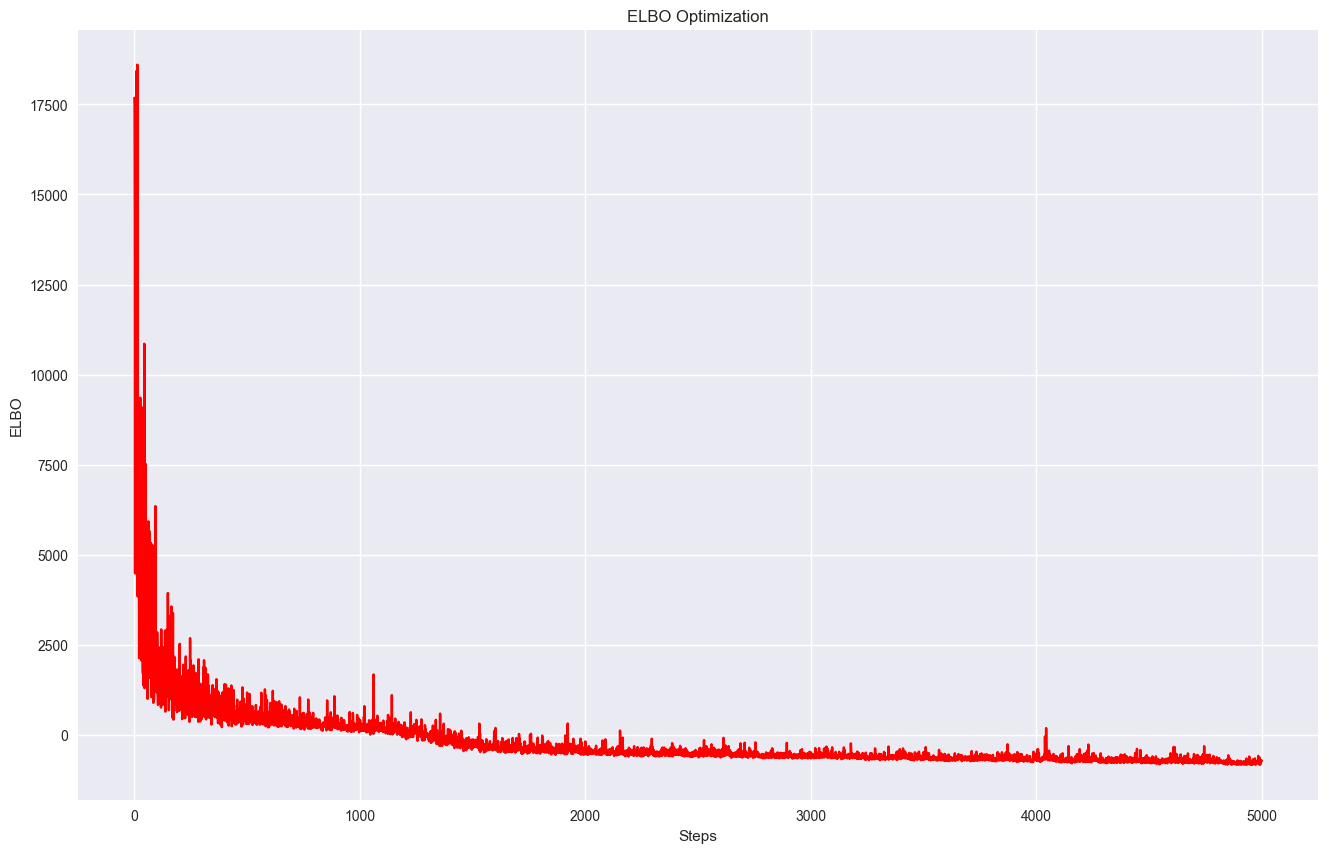

In [31]:
#-----______-----______-----______-----______-----
# Define BNN model
#-----______-----______-----______-----______-----

class BNN(PyroModule):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super(BNN, self).__init__()

        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden1)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden1, n_in]).to_event(2))
        self.in_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden1]).to_event(1))

        self.h_layer1 = PyroModule[nn.Linear](n_hidden1, n_hidden2)
        self.h_layer1.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden1]).to_event(2))
        self.h_layer1.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden2, n_hidden2)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden2]).to_event(2))
        self.h_layer2.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.out_layer = PyroModule[nn.Linear](n_hidden2, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden2]).to_event(2))
        self.out_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_out]).to_event(1))

        self.tanh = nn.Tanh()

    def forward(self, X, y=None):
        X_nn = self.tanh(self.in_layer(X))
        X_nn = self.tanh(self.h_layer1(X_nn))
        X_nn = self.tanh(self.h_layer2(X_nn))
        nn_out = self.out_layer(X_nn).squeeze(-1)

        with pyro.plate("observations", X.shape[0]):
            y = pyro.sample("obs", dist.Normal(nn_out, 0.1), obs=y)

        return nn_out

# Initialize the neural network model
input_dim =X_train.shape[1]  # number of features (-1 for hourDK)
hidden_dim1 = 10  # set first hidden layer dimension
hidden_dim2 = 10  # set second hidden layer dimension
output_dim = 1  # number of output layers

model = BNN(n_in=input_dim, n_hidden1=hidden_dim1, n_hidden2=hidden_dim2, n_out=output_dim)

# Define a guide (variational distribution) for SVI
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Define SVI
elbo = Trace_ELBO(num_particles=3)
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 5000 # set number of optimization steps

# Optimize the model
all_elbo = []
for step in range(n_steps + 1):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    all_elbo.append(elbo)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Plot ELBO values
plt.plot(all_elbo,color='red')
plt.xlabel('Steps')
plt.ylabel('ELBO')
plt.title('ELBO Optimization')
plt.show()

In [32]:
#-----______-----______-----______-----______-----
# Define plots used to compare preited values to true values
#-----______-----______-----______-----______-----
def plot_combined_forecast(train_obs_samples, train_dates, y_train,test_obs_samples, test_dates, y_test,ylabel, title, train_test_split_date):
    #reshaping
    y_train_mean = train_obs_samples.mean(axis=0).reshape(-1,)
    y_train_std = train_obs_samples.std(axis=0).reshape(-1,)
    y_test_mean = test_obs_samples.mean(axis=0).reshape(-1,)
    y_test_std = test_obs_samples.std(axis=0).reshape(-1,)

    # Calculating mean and std for data
    forecast_train_plus_stddev = y_train_mean + 1.96 * y_train_std
    forecast_train_minus_stddev = y_train_mean - 1.96 * y_train_std
    forecast_test_plus_stddev = y_test_mean + 1.96 * y_test_std
    forecast_test_minus_stddev = y_test_mean - 1.96 * y_test_std

    plt.figure(figsize=(20, 7))

    # Plotting only the last 240 training data points
    plt.plot(train_dates[-240:], y_train[-240:], "b-", linewidth=2, label="True")
    plt.plot(train_dates[-240:], y_train_mean[-240:], "r-", linewidth=2, label="Forecast")
    plt.fill_between(train_dates[-240:], forecast_train_minus_stddev[-240:], forecast_train_plus_stddev[-240:], color='red', alpha=0.15, label="Uncertainty")

    # Plot only the first 240 testing data points
    plt.plot(test_dates[:240], y_test[:240], "b-", linewidth=2)
    plt.plot(test_dates[:240], y_test_mean[:240], "r-", linewidth=2)
    plt.fill_between(test_dates[:240], forecast_test_minus_stddev[:240], forecast_test_plus_stddev[:240], color='red', alpha=0.15)

    # Train test split line
    plt.axvline(x=train_test_split_date, color='green', linestyle=':', lw=3, label='Train-test split')

    plt.title(title, size=20)
    plt.ylabel(ylabel, size=15)
    plt.legend(fontsize=13)
    plt.xticks(size=12)
    plt.yticks(size=12)

    # Date formatting
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.xticks(rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

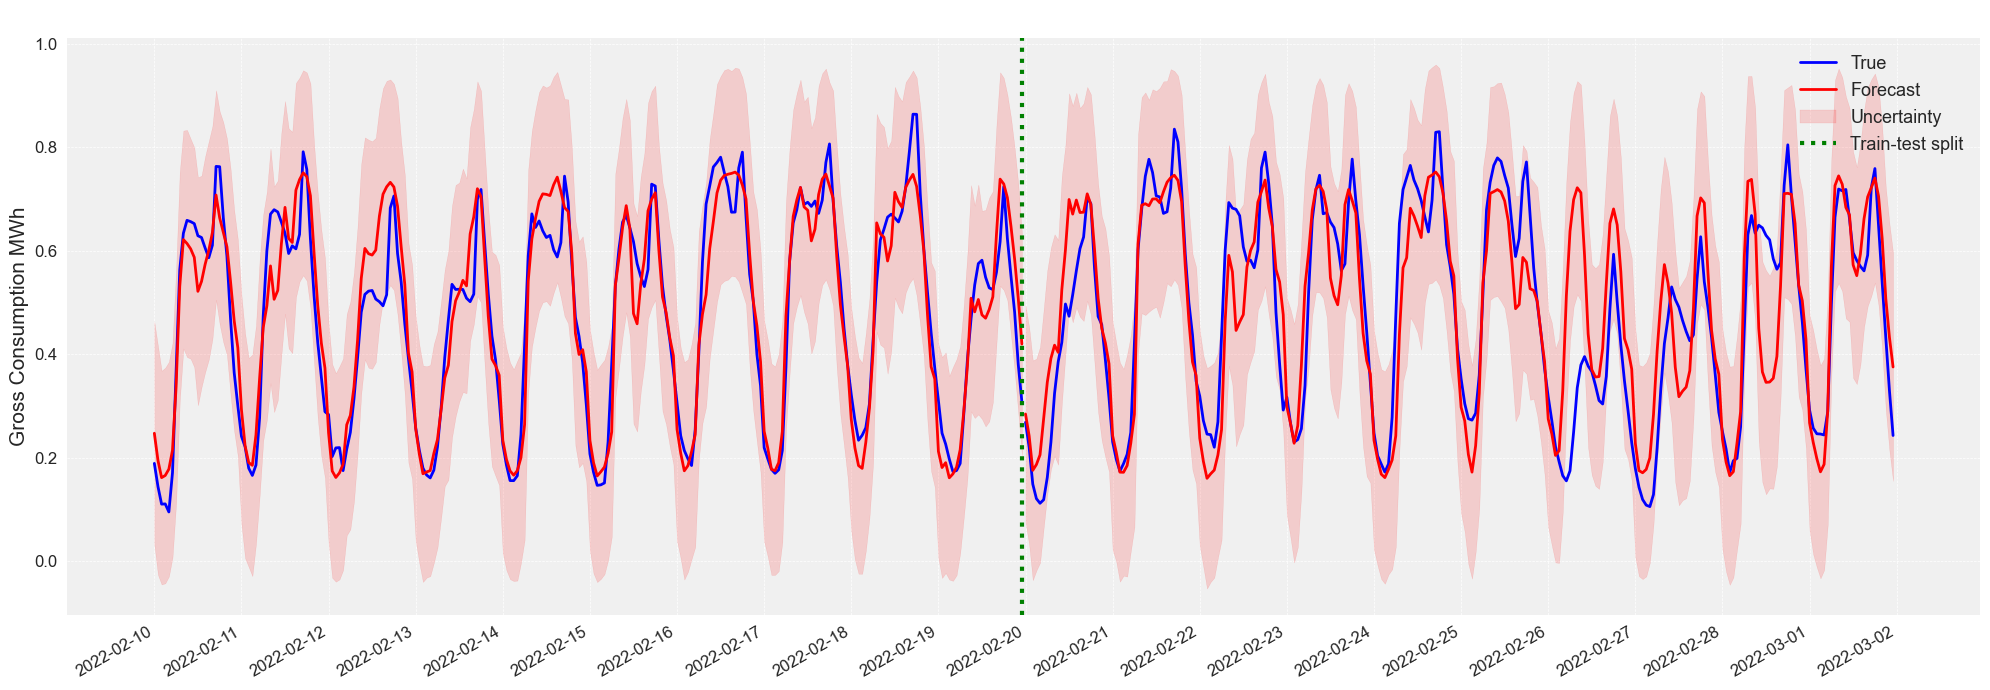

In [33]:
#-----______-----______-----______-----______-----
# Run code predicting true demand vs predicted demand from BNN
#-----______-----______-----______-----______-----
# generate predictions
predictive = Predictive(model, guide=guide, num_samples=1000)

# Get predictions for training data
train_samples = predictive(X_train_tensor)
train_obs_samples = train_samples["obs"].detach().numpy()

# Get predictions for test data
test_samples = predictive(X_test_tensor)
test_obs_samples = test_samples["obs"].detach().numpy()

# Converting dates from dataset for plotting
train_dates = pd.to_datetime(train_data['HourDK'])
test_dates = pd.to_datetime(test_data['HourDK'])

#plot the results
plot_combined_forecast(train_obs_samples, train_dates, y_train,test_obs_samples, test_dates, y_test,"Gross Consumption MWh", " ", train_dates.iloc[-1])


Mean Absolute Error (MAE): 0.0795
Mean Squared Error (MSE): 0.0122
Mean Percentage Error (MPE): 7.8745%


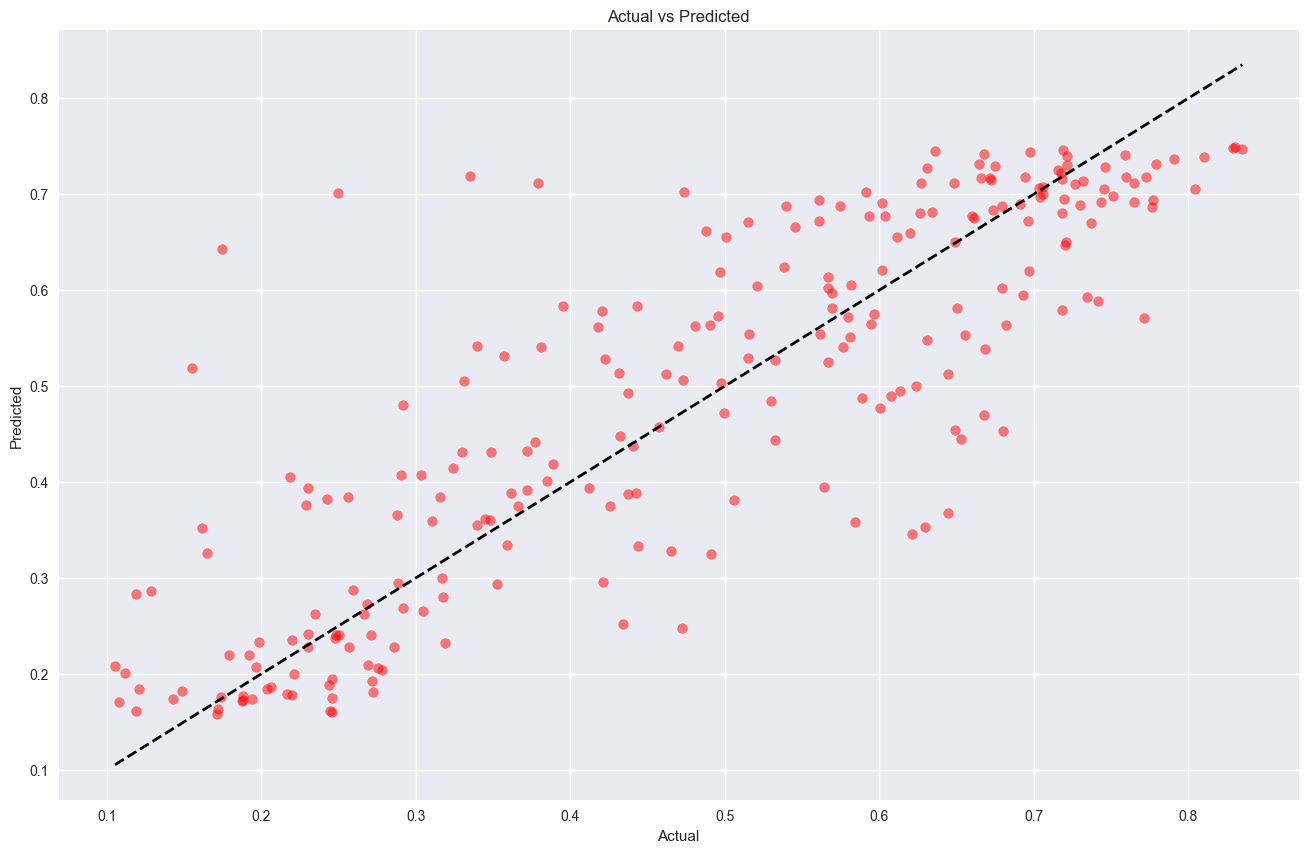

In [34]:
predictive = Predictive(model, guide=guide, num_samples=1000)
samples = predictive(X_test_tensor)

# Calculate mean predictions
y_pred = samples["obs"].mean(dim=0).detach().numpy()

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Calculate Mean Percentage Error (MPE)
mpe = abs(np.mean((y_test - y_pred) / y_test) * 100)
print(f"Mean Percentage Error (MPE): {mpe:.4f}%")

# Plot actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.5,color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

# Hierarchical BNN model - Predicting Demand

This part predicts the demand using similar features to the previous part but has a an extra feature 'is_weekend' which is a clear distinction for the model to learn from i.e wether it is a weekend or not, this is done to encapsulate difference in weekend and weekday electricity demand and potentially lower the mean percentage error.

In [10]:
#-----______-----______-----______-----______-----
# Initialize data -- simmilar to BNN model but with is_weekend data 
#-----______-----______-----______-----______-----

# Add 'is_weekend' feature in training and test data sets
train_data['day_of_week'] = train_data['HourDK'].dt.dayofweek
train_data['is_weekend'] = train_data['day_of_week'] >= 5  # 0 is Monday, 6 is Sunday
test_data['day_of_week'] = test_data['HourDK'].dt.dayofweek
test_data['is_weekend'] = test_data['day_of_week'] >= 5

# Convert 'is_weekend' to int
train_data['is_weekend'] = train_data['is_weekend'].astype(int)
test_data['is_weekend'] = test_data['is_weekend'].astype(int)

#feature selection
X_train = train_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover','SpotPriceDKK','is_weekend']].values
X_test = test_data[['hour', 'Wind', 'Solar', 'Power', 'hourly_temperature_2m', 'cloud_cover','SpotPriceDKK','is_weekend']].values

# target variable for train
y_train = train_data['GrossConsumptionMWh'].values
y_test = test_data['GrossConsumptionMWh'].values

# Convert data to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


[0] ELBO: 7239.7
[1000] ELBO: 2.7
[2000] ELBO: -471.7
[3000] ELBO: -566.7
[4000] ELBO: -788.2
[5000] ELBO: -996.2


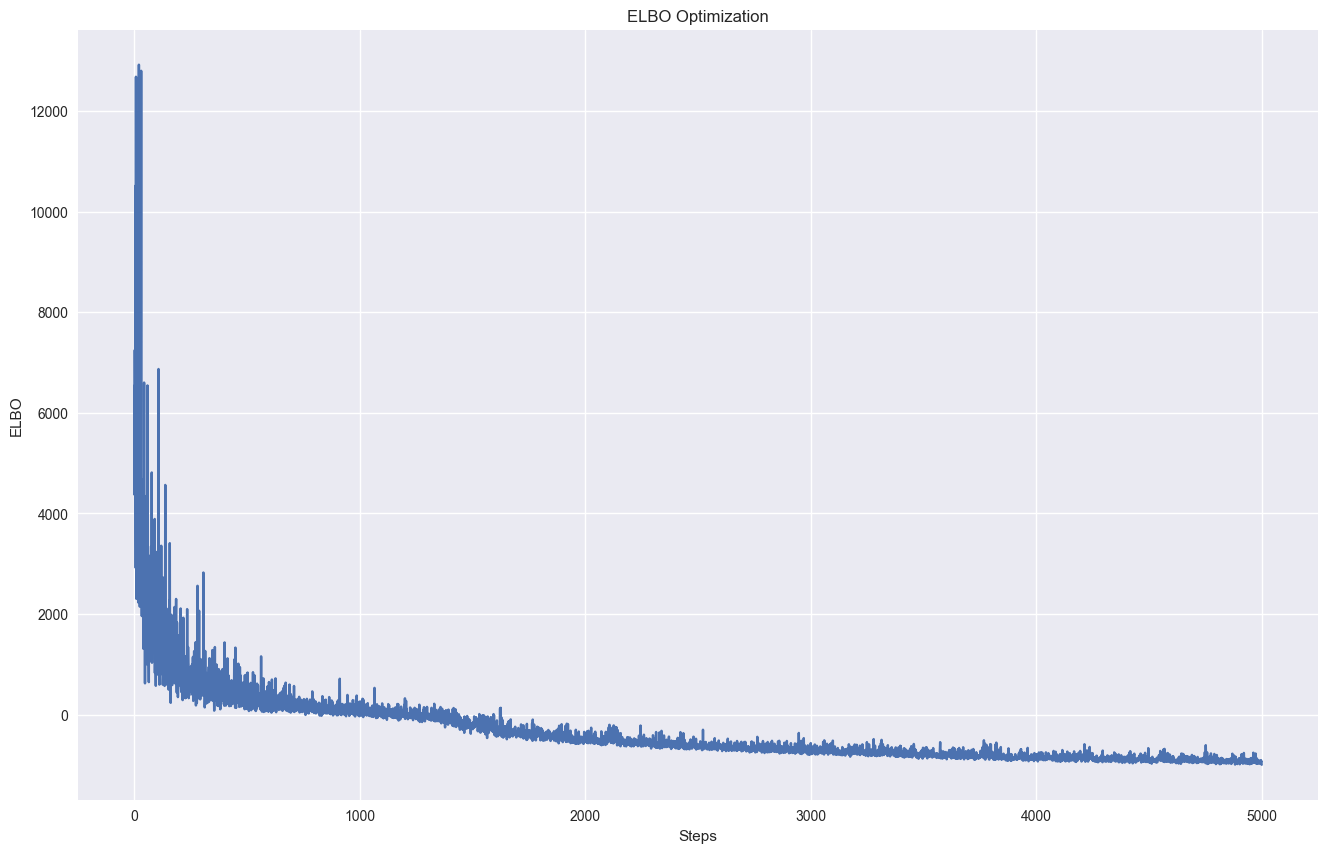

In [11]:
#-----______-----______-----______-----______-----
# Define and run Hierarchical-BNN model
#-----______-----______-----______-----______-----
class HierarchicalBNN(PyroModule):
    def __init__(self, n_in, n_hidden1, n_hidden2, n_out):
        super(HierarchicalBNN, self).__init__()

        self.in_layer = PyroModule[nn.Linear](n_in, n_hidden1)
        self.in_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden1, n_in]).to_event(2))
        self.in_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden1]).to_event(1))

        self.h_layer1 = PyroModule[nn.Linear](n_hidden1, n_hidden2)
        self.h_layer1.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden1]).to_event(2))
        self.h_layer1.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.h_layer2 = PyroModule[nn.Linear](n_hidden2, n_hidden2)
        self.h_layer2.weight = PyroSample(dist.Normal(0., 1.).expand([n_hidden2, n_hidden2]).to_event(2))
        self.h_layer2.bias = PyroSample(dist.Normal(0., 1.).expand([n_hidden2]).to_event(1))

        self.out_layer = PyroModule[nn.Linear](n_hidden2, n_out)
        self.out_layer.weight = PyroSample(dist.Normal(0., 1.).expand([n_out, n_hidden2]).to_event(2))
        self.out_layer.bias = PyroSample(dist.Normal(0., 1.).expand([n_out]).to_event(1))

        #Added weekend effects
        self.weekend_effects = PyroModule[nn.Embedding](2, n_out)
        self.weekend_effects.weight = PyroSample(dist.Normal(0., 1.).expand([2, n_out]).to_event(2))

        self.tanh = nn.Tanh()

    def forward(self, X, y=None):
        is_weekend = X[:, -1].long()
        X_nn = self.tanh(self.in_layer(X[:, :-1]))
        X_nn = self.tanh(self.h_layer1(X_nn))
        X_nn = self.tanh(self.h_layer2(X_nn))
        nn_out = self.out_layer(X_nn).squeeze(-1)
        weekend_effect = self.weekend_effects(is_weekend).squeeze(-1)

        with pyro.plate("observations", X.shape[0]):
            y = pyro.sample("obs", dist.Normal(nn_out + weekend_effect, 0.1), obs=y)

        return nn_out + weekend_effect

# Initialize the hierarchical BNN model
input_dim = X_train.shape[1] - 1   # Number of features excluding the is_weekend column
hidden_dim1 = 10  #  first hidden layer dimension
hidden_dim2 = 10  #  second hidden layer dimension
output_dim = 1  # number of output layers

model = HierarchicalBNN(n_in=input_dim, n_hidden1=hidden_dim1, n_hidden2=hidden_dim2, n_out=output_dim)

# Define a guide (variational distribution) for SVI
pyro.clear_param_store()
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)

# Define SVI
elbo = Trace_ELBO(num_particles=3)
optimizer = Adam({"lr": 0.01})
svi = SVI(model, guide, optimizer, loss=elbo)
n_steps = 5000 #set number of optimization steps

# Optimize the model
all_elbo = []
for step in range(n_steps + 1):
    elbo = svi.step(X_train_tensor, y_train_tensor)
    all_elbo.append(elbo)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

# Plot ELBO values
plt.plot(all_elbo)
plt.xlabel('Steps')
plt.ylabel('ELBO')
plt.title('ELBO Optimization')
plt.show()


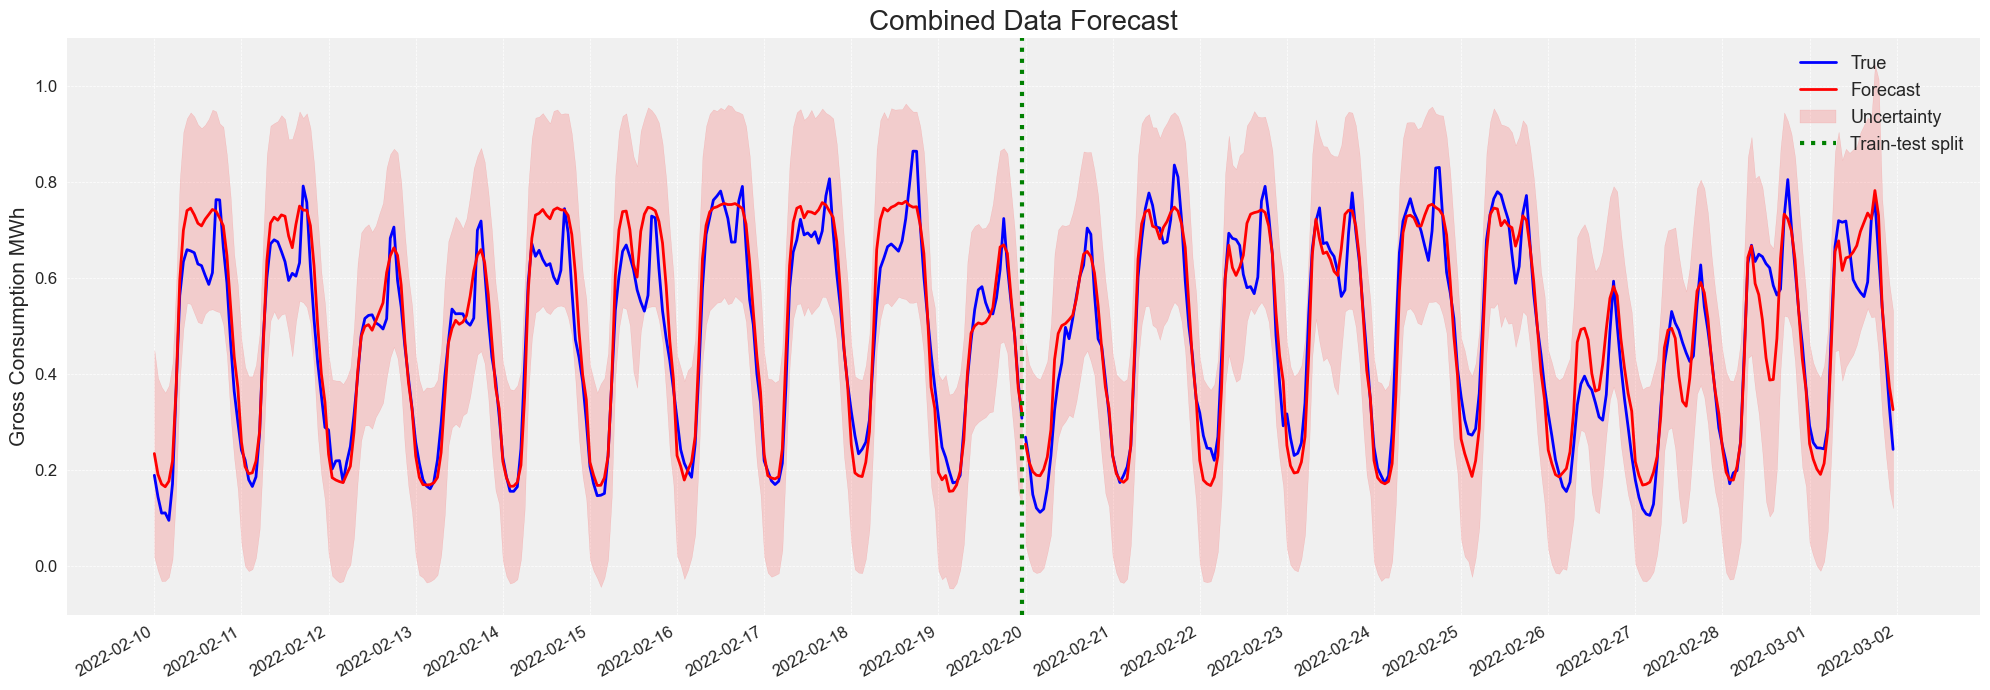

In [14]:
#-----______-----______-----______-----______-----
# Run code predicting true demand vs predicted demand from Heiarchical-BNN
#-----______-----______-----______-----______-----
predictive = Predictive(model, guide=guide, num_samples=1000)
samples = predictive(X_test_tensor)

# Calculate mean predictions
y_pred = samples["obs"].mean(dim=0).detach().numpy()

# Get predictions for training data
train_samples = predictive(X_train_tensor)
train_obs_samples = train_samples["obs"].detach().numpy()

# Get predictions for test data
test_samples = predictive(X_test_tensor)
test_obs_samples = test_samples["obs"].detach().numpy()

# Convert dates from your dataset for plotting
train_dates = pd.to_datetime(train_data['HourDK'])
test_dates = pd.to_datetime(test_data['HourDK'])

#plot the results
plot_combined_forecast(train_obs_samples, train_dates, y_train,test_obs_samples, test_dates, y_test,"Gross Consumption MWh", "Combined Data Forecast", train_dates.iloc[-1])


Mean Absolute Error (MAE): 0.0479
Mean Squared Error (MSE): 0.0040
Mean Percentage Error (MPE): 1.6284%


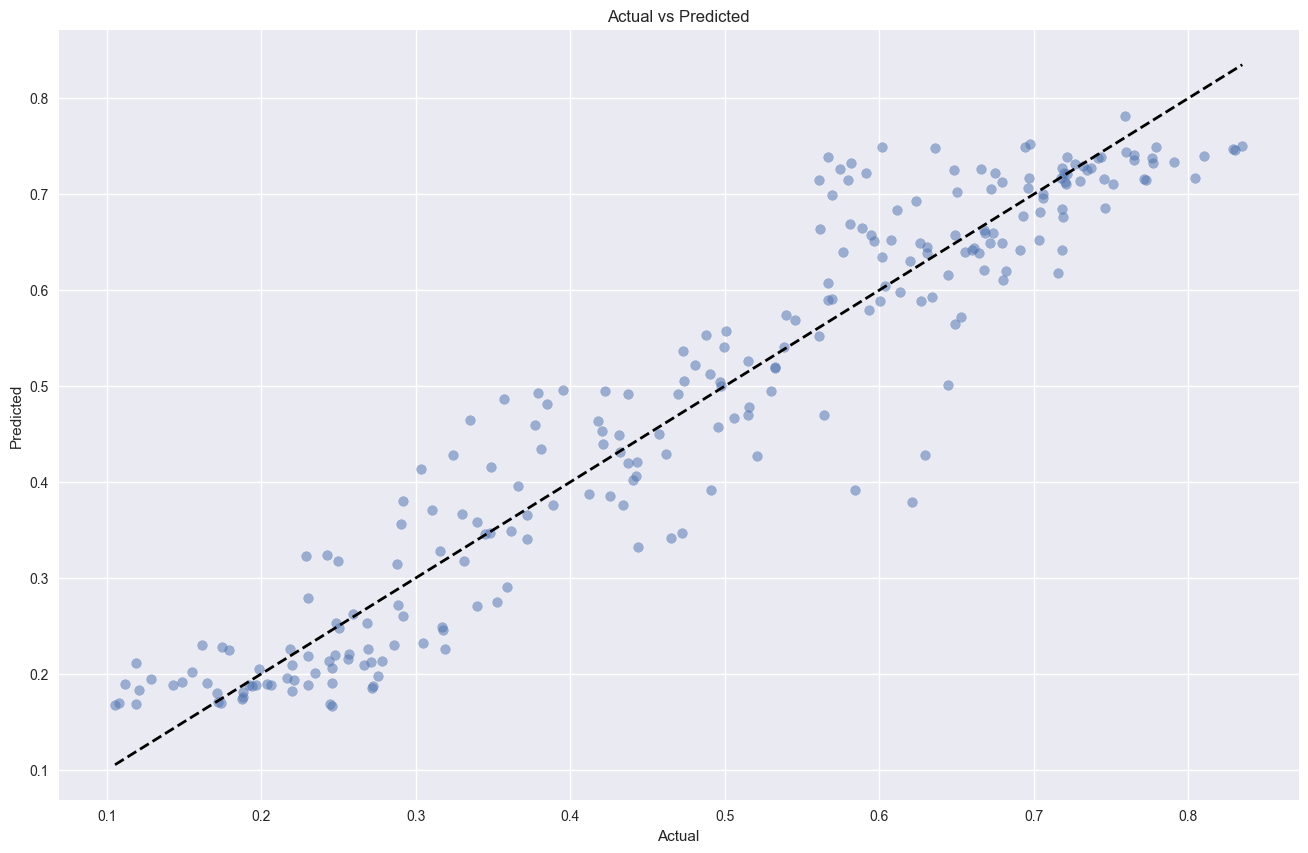

In [15]:
# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
# Calculate Mean Percentage Error (MPE)
mpe = abs(np.mean((y_test - y_pred) / y_test) * 100)
print(f"Mean Percentage Error (MPE): {mpe:.4f}%")

# Plot actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

As shown, the hierarchical model is a significant improvement, to the standard BNN. Significantly both models have shown a decent accuracy when predicting the gross_consumption/demand of electricity. 